# Hybrid Recommender (Pitch Version)

This is a simple demo to explain how our hybrid AI picks items:

- We combine two signals:
  - Collaborative Filtering (CF): "people like you also liked..."
  - Popularity: "what’s trending overall"
- We compute a score from CF and a score from Popularity for each item.
- We blend them with simple weights into a single hybrid score.
- We show a quick comparison chart of the top items.

Adjustable parts for the demo:
- `user_id`: which user we’re recommending for
- `w_cf` and `w_pop`: sliders (numbers) to show how weights change rankings
- `K`: how many top items to show


In [7]:
# Simple Hybrid Recommender Visualization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configure display
pd.set_option('display.max_columns', 50)

# Paths
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent
DATA_DIR = PROJECT_ROOT / 'data' / 'raw'

print(f"Data directory: {DATA_DIR}")

# Load datasets
orders = pd.read_csv(DATA_DIR / 'orders.csv')
order_items = pd.read_csv(DATA_DIR / 'order_items.csv')
items = pd.read_csv(DATA_DIR / 'items.csv')
users = pd.read_csv(DATA_DIR / 'users.csv')

print('Shapes:')
print({'orders': orders.shape, 'order_items': order_items.shape, 'items': items.shape, 'users': users.shape})

# Merge for convenience
orders_items = orders.merge(order_items, on='order_id', how='inner')
orders_items.head()


Data directory: c:\Users\lenovo\Desktop\nexo_backend\Hack\smart_menu\data\raw
Shapes:
{'orders': (100, 4), 'order_items': (228, 6), 'items': (20, 14), 'users': (20, 20)}


,order_id,user_id,timestamp,total_amount,item_id,quantity,price,added_ingredients,removed_ingredients
0,1,16,2025-09-06 07:43:14.017829,25.98,6,2,12.99,"onions,olives",NaN
1,2,18,2025-09-19 07:43:14.017829,77.96,12,3,22.99,NaN,onions
2,2,18,2025-09-19 07:43:14.017829,77.96,7,1,8.99,NaN,onions
3,3,3,2025-09-25 07:43:14.017829,74.94,20,3,9.99,peppers,"olives,mushrooms"
4,3,3,2025-09-25 07:43:14.017829,74.94,10,3,14.99,"peppers,cheese",peppers


In [8]:
# Build user-item interaction matrix (quantities)

ui = orders_items.pivot_table(index='user_id', columns='item_id', values='quantity', aggfunc='sum', fill_value=0)
print('User-Item matrix shape:', ui.shape)
ui.head()


User-Item matrix shape: (20, 20)


item_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
user_id,,,,,,,,,,,,,,,,,,,,
1,0,2,0,0,2,0,0,0,0,0,0,3,0,0,0,0,0,0,1,0
2,1,0,2,0,0,2,5,2,0,1,0,0,0,0,7,3,3,0,0,5
3,0,0,0,0,0,0,0,0,0,3,0,0,0,1,0,0,0,2,0,3
4,0,0,0,1,0,3,4,3,0,0,0,7,0,3,0,0,3,3,0,0
5,5,3,0,1,0,3,0,0,0,0,0,0,1,0,2,0,0,1,4,0


In [9]:
# Item-item cosine similarity and CF scores (no extra plots)

from numpy.linalg import norm

def cosine(a, b):
    denom = (norm(a) * norm(b))
    return 0.0 if denom == 0 else float(a @ b) / float(denom)

# Compute item-item similarity matrix
item_ids = ui.columns.to_list()
U = ui.values
n_items = U.shape[1]
sim = np.zeros((n_items, n_items), dtype=float)
for i in range(n_items):
    for j in range(n_items):
        sim[i, j] = cosine(U[:, i], U[:, j])

sim_df = pd.DataFrame(sim, index=item_ids, columns=item_ids)

# CF scoring for a chosen user: score = sum_purchased(similarity)
user_id = int(users['user_id'].iloc[0])
user_vec = ui.loc[user_id]
raw_scores = sim_df.mul(user_vec.values, axis=0).sum(axis=0)

# Remove already purchased heavy bias by zeroing owned items (optional)
owned = set(ui.columns[user_vec.values > 0])
cf_scores = raw_scores.copy()
for iid in owned:
    cf_scores.loc[iid] = 0.0

# Normalize 0..1
cf_scores = (cf_scores - cf_scores.min()) / (cf_scores.max() - cf_scores.min() + 1e-6)
cf_scores = cf_scores.sort_values(ascending=False)
cf_scores.head(10)


1     1.000000
9     0.984012
14    0.774212
6     0.773265
13    0.724354
18    0.714994
15    0.667586
7     0.648956
11    0.610325
4     0.605816
dtype: float64

In [10]:
# Simple popularity/context proxy scoring

# Popularity: total quantities across users with mild recency (if timestamp exists)
if 'timestamp' in orders.columns:
    orders['timestamp'] = pd.to_datetime(orders['timestamp'])
    merged = orders.merge(order_items, on='order_id', how='inner')
    now = orders['timestamp'].max()
    age_days = (now - merged['timestamp']).dt.days.clip(lower=0)
    decay = 0.5 ** (age_days / 30.0)
    pop_raw = merged.groupby('item_id').apply(lambda g: (g['quantity'] * decay.loc[g.index]).sum())
else:
    pop_raw = order_items.groupby('item_id')['quantity'].sum()

pop_scores = (pop_raw - pop_raw.min()) / (pop_raw.max() - pop_raw.min() + 1e-6)

# Align index to all items and fill missing with 0
pop_scores = pop_scores.reindex(items['item_id']).fillna(0.0)

pop_scores.sort_values(ascending=False).head(10)


C:\Users\lenovo\AppData\Local\Temp\ipykernel_46232\1773289849.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pop_raw = merged.groupby('item_id').apply(lambda g: (g['quantity'] * decay.loc[g.index]).sum())


item_id
12    1.000000
10    0.891207
1     0.851756
7     0.808132
20    0.791336
6     0.704709
15    0.606013
18    0.537285
4     0.510655
19    0.480439
dtype: float64

In [11]:
# Combine CF and Popularity into a simple Hybrid score

# Ensure aligned indices
cf_aligned = cf_scores.reindex(items['item_id']).fillna(0.0)
pop_aligned = pop_scores.reindex(items['item_id']).fillna(0.0)

# Adjustable weights
w_cf = 0.6
w_pop = 0.4

hybrid = (w_cf * (cf_aligned + 1e-6))**1.0 * (w_pop * (pop_aligned + 1e-6))**1.0
# Alternatively, simple weighted sum:
# hybrid = w_cf * cf_aligned + w_pop * pop_aligned

# Normalize 0..1 for plotting
hybrid = (hybrid - hybrid.min()) / (hybrid.max() - hybrid.min() + 1e-6)

# Build a tidy DataFrame with names
names = items.set_index('item_id')['name']
rec_df = pd.DataFrame({
    'name': names,
    'cf': cf_aligned,
    'popularity': pop_aligned,
    'hybrid': hybrid
}).fillna(0.0)

rec_top = rec_df.sort_values('hybrid', ascending=False).head(10)
rec_top


,name,cf,popularity,hybrid
item_id,,,,
1,Margherita Pizza,1.000000,0.851756,0.999995
6,Veggie Burger,0.773265,0.704709,0.639766
10,Veggie Pasta,0.596539,0.891207,0.624167
7,Chocolate Cake,0.648956,0.808132,0.615716
15,Fresh Juice,0.667586,0.606013,0.474977
18,Pancakes,0.714994,0.537285,0.451014
4,Grilled Chicken Salad,0.605816,0.510655,0.363204
9,Pasta Carbonara,0.984012,0.229536,0.265176
20,Veggie Wrap,0.280471,0.791336,0.260575


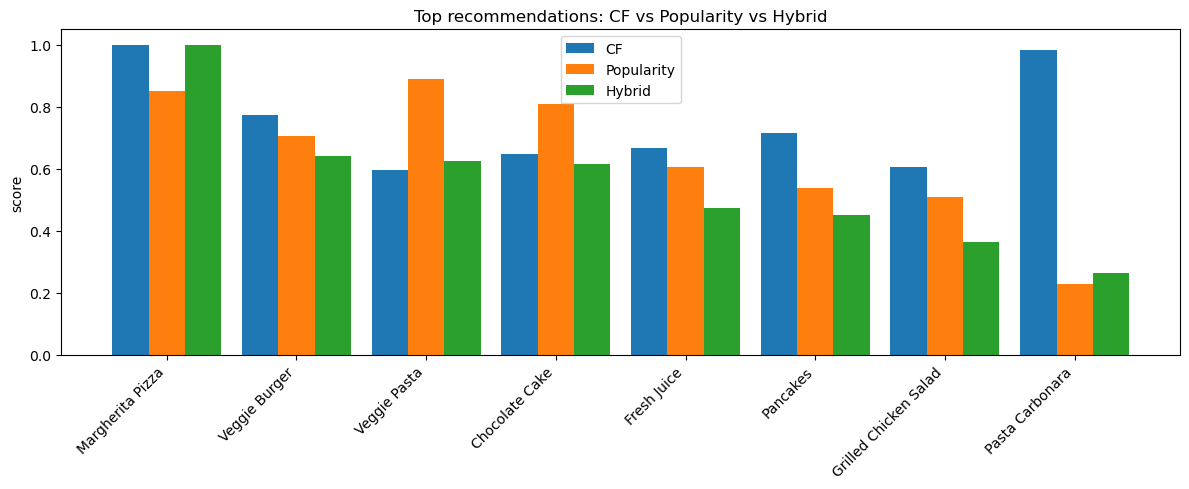

In [12]:
# Visualize: single grouped comparison bar chart

K = 8
plot_df = rec_top.head(K).copy()

x = np.arange(len(plot_df))
width = 0.28

fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(x - width, plot_df['cf'], width, label='CF')
ax.bar(x, plot_df['popularity'], width, label='Popularity')
ax.bar(x + width, plot_df['hybrid'], width, label='Hybrid')

ax.set_ylabel('score')
ax.set_title('Top recommendations: CF vs Popularity vs Hybrid')
ax.set_xticks(x)
ax.set_xticklabels(plot_df['name'], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()
